# Heuristics 
> This notebook reimplements and prints different heuristics from Nolle 2019 including
- elbow_up
- elbow_down
- lowest_plateau_left
- lowest_plateau_right
- lowest_plateau_centered
- best

> Additional we show the how prediction score normalization affects the anomaly ratio curve and leads to a performance boost im terms of F1-Score on the anomaly detection task

In [ ]:
#default_exp heuristics

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-Anomaly-Scores:" data-toc-modified-id="Get-Anomaly-Scores:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get Anomaly Scores:</a></span></li><li><span><a href="#Get-Predictions-per-threshold" data-toc-modified-id="Get-Predictions-per-threshold-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get Predictions per threshold</a></span></li><li><span><a href="#Heuristics" data-toc-modified-id="Heuristics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Heuristics</a></span><ul class="toc-item"><li><span><a href="#Best-Threshold" data-toc-modified-id="Best-Threshold-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Best Threshold</a></span></li><li><span><a href="#Fixed-Threshold" data-toc-modified-id="Fixed-Threshold-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Fixed Threshold</a></span></li><li><span><a href="#Ratio-Heuristic" data-toc-modified-id="Ratio-Heuristic-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ratio Heuristic</a></span></li><li><span><a href="#Ellbow-Heuristic" data-toc-modified-id="Ellbow-Heuristic-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Ellbow Heuristic</a></span></li><li><span><a href="#Lowest-Plateau-Heuristic" data-toc-modified-id="Lowest-Plateau-Heuristic-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Lowest Plateau Heuristic</a></span></li></ul></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization</a></span></li><li><span><a href="#Impact-of-Prediction-Score-Normalization" data-toc-modified-id="Impact-of-Prediction-Score-Normalization-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Impact of Prediction Score Normalization</a></span></li></ul></div>

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
from dapnn.imports import *
from dapnn.data_processing import *

from dapnn.anomaly import * 
import seaborn as sns
sns.set_theme(style="darkgrid")

In [ ]:
notebook2script('05_heuristics.ipynb')

Converted 05_heuristics.ipynb.


## Get Anomaly Scores:

In [ ]:
#export
from sklearn.metrics import confusion_matrix

def f_score(y_true, y_pred,sample_weight=None):
    C = confusion_matrix(y_true, y_pred, sample_weight=sample_weight)
    with np.errstate(divide="ignore", invalid="ignore"):
        per_class = np.diag(C) / C.sum(axis=1)
    if np.any(np.isnan(per_class)):
        warnings.warn("y_pred contains classes not in y_true")
        per_class = per_class[~np.isnan(per_class)]
    P = per_class[0]
    N = per_class[1]
    score = 2*(P*N)/(P+N)
    return score

In [ ]:
#export
def load_pred_model(learner_path,train_log_path,log_name,cols=['activity']):
    p = f'{learner_path}/{log_name}_vocab.p'
    with open(p, 'rb') as fp:
        categorify = pickle.load(fp)
    log = import_log(train_log_path)
    o = process_test(log,categorify,cols)
    dls=o.get_dls()
    loss=partial(multi_loss_sum,o)
    emb_szs = get_emb_sz(o)
    m=MultivariateModel(emb_szs)
    learn=Learner(dls, m, path=learner_path, model_dir='.', loss_func=loss, metrics=get_metrics(o))
    learn.load(log_name,with_opt=False)
    m=learn.model.cuda()
    return m, categorify

In [ ]:
#export
def multivariate_anomaly_score(res,o,idx,cols,normalization = True):
    score_df=pd.DataFrame()

    for cidx,_ in enumerate(cols):
        sm = nn.Softmax(dim=1)
        p = sm(res[cidx].cpu())
        pred = p.max(1)[0]
        y = o.items[cols[cidx]].iloc[idx].values

        truth=p[list(range(len(y))),y]
        if normalization:
            score = ((pred - truth) / pred).tolist()
        else:
            score = (pred - truth).tolist()
        score_df[cols[cidx]] = score
    score_df['trace_id']=o.items['trace_id'].iloc[idx].values
    return score_df

In [ ]:
#export
def get_score_df(log_name,pdc_year=2020,prediction_normalization = True):
    learner_path=f'models/pdc{pdc_year}'
    training_log_path = f'data/csv/PDC{pdc_year}_training/pdc_{pdc_year}_{log_name}.csv.gz'
    test_log_path = f'data/csv/PDC{pdc_year}_ground_truth/pdc_{pdc_year}_{log_name}.csv.gz' 
    
    cols = ['activity']
    m, categorify= load_pred_model(learner_path,training_log_path,log_name)
    if type(test_log_path)==str:
        log = import_log(test_log_path)
    else:
        log = test_log_path   
    o = process_test(log,categorify,cols)
    nsp,idx=predict_next_step(o,m)
    score_df=multivariate_anomaly_score(nsp,o,idx,cols,prediction_normalization)
    y_true =o.items.groupby(o.items.index)['normal'].mean().to_numpy() == False
    return score_df,y_true

In [ ]:
log_name = '1001001'
score_df,y_true = get_score_df(log_name)

## Get Predictions per threshold

In [ ]:
#export
def get_preds(score_df,threshold):
    h =score_df.groupby('trace_id')['activity'].max()
    h=(h-h.min())/(h.max()-h.min())

    y_pred = (h.to_numpy()>threshold).astype(int)
    return y_pred


In [ ]:
ths = np.array((range(1000)))*0.001 +0.0
ths[:20]

array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019])

In [ ]:
#export
def get_th_df(ths,score_df,y_true,log_name,f_score=f_score):
    res = []
    for t in progress_bar(ths):
        y_pred=get_preds(score_df,t)
        anomaly_ratio = sum(x == 1 for x in y_pred) / len(y_pred)
        f1 = f_score(y_true, y_pred)
        precision = precision_score(y_true,y_pred)
        recall = recall_score(y_true,y_pred)
        res.append([log_name, f1, precision, recall, anomaly_ratio])

    columns='Log Name', 'F1 Score','Precision','Recall', 'Anomaly Ratio'
    th_df = pd.DataFrame(res,columns=columns,index=ths)
    return th_df


In [ ]:
th_df = get_th_df(ths,score_df,y_true,log_name)
th_df

,Log Name,F1 Score,Precision,Recall,Anomaly Ratio
0.000,1001001,0.003914,0.490490,1.000000,0.999
0.001,1001001,0.003914,0.490490,1.000000,0.999
0.002,1001001,0.003914,0.490490,1.000000,0.999
0.003,1001001,0.003914,0.490490,1.000000,0.999
0.004,1001001,0.007812,0.490982,1.000000,0.998
...,...,...,...,...,...
0.995,1001001,0.747303,0.993220,0.597959,0.295
0.996,1001001,0.706633,0.996283,0.546939,0.269
0.997,1001001,0.662597,0.995902,0.495918,0.244
0.998,1001001,0.603989,1.000000,0.432653,0.212


## Heuristics

###  Best Threshold

In [ ]:
#export
def get_best_threshhold(th_df): return th_df.iloc[th_df['F1 Score'].argmax()]


In [ ]:
best_threshhold = get_best_threshhold(th_df)
best_threshhold

Log Name          1001001
F1 Score         0.971086
Precision        0.963783
Recall           0.977551
Anomaly Ratio       0.497
Name: 0.924, dtype: object

### Fixed Threshold

In [ ]:
#export
def get_fixed_heuristic(fixed,th_df): return th_df.iloc[np.absolute(th_df.index.to_numpy()-fixed).argmin()]


In [ ]:
fixed = 0.98

fixed_heuristic =get_fixed_heuristic(fixed,th_df)
fixed_heuristic

Log Name          1001001
F1 Score          0.92415
Precision        0.983834
Recall           0.869388
Anomaly Ratio       0.433
Name: 0.98, dtype: object

### Ratio Heuristic

In [ ]:
#export
def get_ratio_th(ratio,th_df):return th_df.iloc[th_df['Anomaly Ratio'].sub(ratio).abs().argmin()]


In [ ]:
ratio =0.5
ratio_heuristic =get_ratio_th(ratio,th_df)
ratio_heuristic

Log Name          1001001
F1 Score         0.967096
Precision        0.956088
Recall           0.977551
Anomaly Ratio       0.501
Name: 0.921, dtype: object

In [ ]:
partial(get_ratio_th,0.5)

functools.partial(<function get_ratio_th at 0x7fa7d44da4c0>, 0.5)

### Ellbow Heuristic

In [ ]:
#export
def elbow_heuristic(th_df):
    taus = th_df.index.to_numpy()
    r = th_df['Anomaly Ratio'].to_numpy()
    step = taus[1:] - taus[:-1]
    r_prime_prime = (r[2:] - 2 * r[1:-1] + r[:-2]) / (step[1:] * step[:-1])
    ellbow_down = th_df.iloc[np.argmax(r_prime_prime) + 1]
    ellbow_up = th_df.iloc[np.argmin(r_prime_prime) + 1]
    return ellbow_down,ellbow_up


In [ ]:
ellbow_down,ellbow_up = elbow_heuristic(th_df)
ellbow_down,ellbow_up

(Log Name          1001001
 F1 Score          0.75836
 Precision        0.993377
 Recall           0.612245
 Anomaly Ratio       0.302
 Name: 0.994, dtype: object,
 Log Name          1001001
 F1 Score         0.603989
 Precision             1.0
 Recall           0.432653
 Anomaly Ratio       0.212
 Name: 0.998, dtype: object)

### Lowest Plateau Heuristic

In [ ]:
#export
def get_lowest_plateau_heuristic(th_df):
    taus = th_df.index.to_numpy()
    r = th_df['Anomaly Ratio'].to_numpy()
    r_prime = (r[1:] - r[:-1]) / (taus[1:] - taus[:-1])
    stable_region = r_prime > np.mean(r_prime) / 2
    regions = np.split(np.arange(len(stable_region)), np.where(~stable_region)[0])
    regions = [taus[idx[1:]] for idx in regions if len(idx) > 1]
    if len(regions) == 0:
        regions = [taus[-2:]]
    lp_min = get_fixed_heuristic(regions[-1].min(),th_df)
    lp_mean = get_fixed_heuristic(regions[-1].mean(),th_df)
    lp_max = get_fixed_heuristic(regions[-1].max(),th_df)
    return lp_min,lp_mean,lp_max


In [ ]:
lp_min,lp_mean,lp_max=get_lowest_plateau_heuristic(th_df)
lp_min,lp_mean,lp_max

(Log Name          1001001
 F1 Score         0.950696
 Precision        0.976293
 Recall            0.92449
 Anomaly Ratio       0.464
 Name: 0.966, dtype: object,
 Log Name          1001001
 F1 Score         0.950696
 Precision        0.976293
 Recall            0.92449
 Anomaly Ratio       0.464
 Name: 0.966, dtype: object,
 Log Name          1001001
 F1 Score         0.950696
 Precision        0.976293
 Recall            0.92449
 Anomaly Ratio       0.464
 Name: 0.967, dtype: object)

## Visualization

In [ ]:
log_name = '1001001'
score_df,y_true = get_score_df(log_name)
ths = np.array((range(100)))*0.001 +0.9
th_df = get_th_df(ths,score_df,y_true,log_name)
heuristics = [get_best_threshhold,partial(get_ratio_th,0.5),elbow_heuristic,
              partial(get_fixed_heuristic,0.98),get_lowest_plateau_heuristic]
heuristic_names = ['best','r_0.5','e_down','e_up','fix','lp_min','lp_mean','lp_max']
heuristic_scores =[i for j in [listify(x(th_df)) for x in heuristics] for i in j]

In [ ]:
#export
def get_plot_data(th_df,id_vars=['Log Name'],value_vars = ['F1 Score','Anomaly Ratio']):
    plot_data=th_df.melt(var_name='Metric',value_name='Score',id_vars =id_vars ,value_vars=value_vars,ignore_index=False)
    plot_data['Threshold']=plot_data.index
    plot_data.index=range(len(plot_data))
    return plot_data


In [ ]:
plot_data = get_plot_data(th_df)

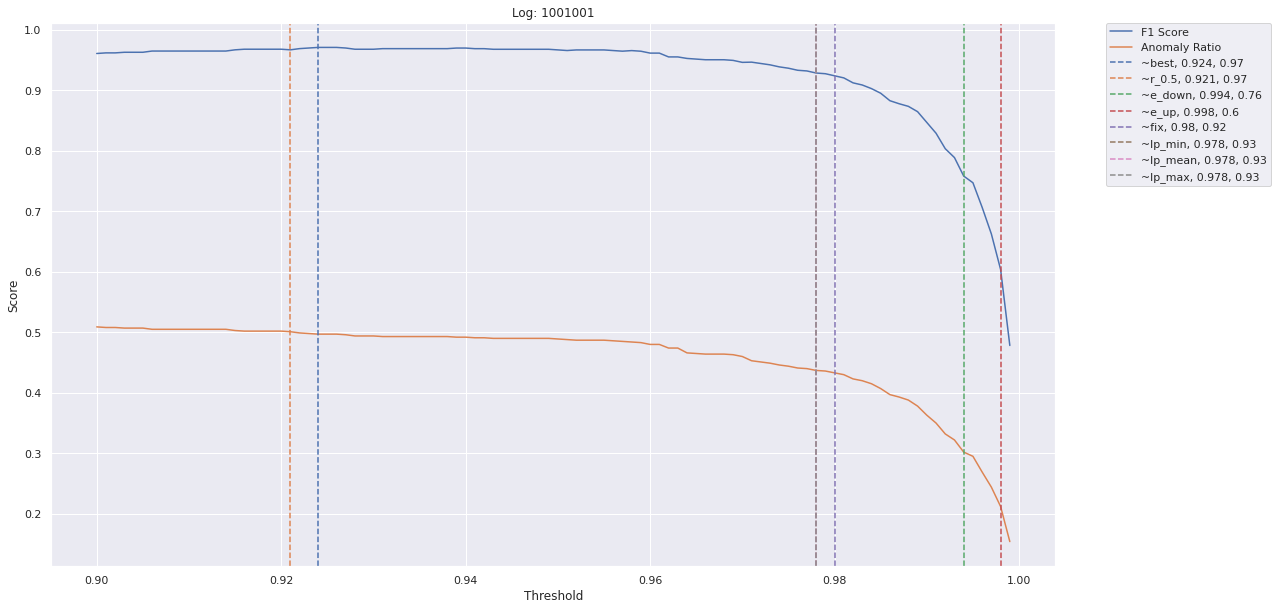

In [ ]:
color_palette = sns.color_palette()
sns.set(rc={'figure.figsize':(18,10)})

sns.lineplot(x="Threshold", y="Score",
             hue="Metric",
             data=plot_data).set(title=f'Log: {log_name}')
for i in range(len(heuristic_scores)):
    plt.axvline(heuristic_scores[i].name, 0,1,color=color_palette[i],linestyle='--',
                label=f"~{heuristic_names[i]}, {heuristic_scores[i].name}, {heuristic_scores[i]['F1 Score'].round(2)}")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [ ]:
pd.DataFrame(zip([i.name for i in heuristic_scores],[i['F1 Score'] for i in heuristic_scores]),
             columns=['Threshold','F1-Score'],index=heuristic_names)

,Threshold,F1-Score
best,0.924,0.971086
r_0.5,0.921,0.967096
e_down,0.994,0.758360
e_up,0.998,0.603989
fix,0.980,0.924150
lp_min,0.978,0.928742
lp_mean,0.978,0.928742
lp_max,0.978,0.928742


## Impact of Prediction Score Normalization

In [ ]:
logs = pd.read_csv('results/pdc2020_0.98_25.csv',dtype={'log_name':str})['log_name']
logs = logs.sample(frac=1)[:3].tolist()
logs

['0110110', '0211101', '0100101']

In [ ]:
res = []
for log_name in progress_bar(logs):
    ths = np.array((range(1000)))*0.001 +0.0   
    score_df,y_true = get_score_df(log_name)
    th_df1 = get_th_df(ths,score_df,y_true,log_name)
    th_df1['Normalization'] = True
    score_df,y_true = get_score_df(log_name,prediction_normalization=False)
    th_df2 = get_th_df(ths,score_df,y_true,log_name)
    th_df2['Normalization'] = False
    res+=[th_df1,th_df2]
    


In [ ]:
heuristic_scores=[]
for df in res:
    df['Threshold'] = df.index
    heuristic_scores.append([i for j in [listify(x(df)) for x in heuristics] for i in j])
th_df = pd.concat(res,ignore_index=True)
th_df.index = th_df['Threshold']
th_df = th_df.drop('Threshold',axis=1)
th_df

,Log Name,F1 Score,Precision,Recall,Anomaly Ratio,Normalization
Threshold,,,,,,
0.000,0110110,0.024561,0.440081,1.000000,0.993,True
0.001,0110110,0.024561,0.440081,1.000000,0.993,True
0.002,0110110,0.024561,0.440081,1.000000,0.993,True
0.003,0110110,0.024561,0.440081,1.000000,0.993,True
0.004,0110110,0.024561,0.440081,1.000000,0.993,True
...,...,...,...,...,...,...
0.995,0100101,0.035635,1.000000,0.018141,0.008,False
0.996,0100101,0.026846,1.000000,0.013605,0.006,False
0.997,0100101,0.026846,1.000000,0.013605,0.006,False


In [ ]:
res2 = []
for i in heuristic_scores:
    for k,j in enumerate(i):
        res2.append([heuristic_names[k],j['Log Name'],j['F1 Score'],j['Anomaly Ratio'],j['Threshold'],j['Normalization']])
df =pd.DataFrame(res2,columns=['Heuristic','Log','F1','Anomaly Ratio','Threshold','Normalization'])
df.sort_values(['Log','Heuristic','Normalization'])

,Heuristic,Log,F1,Anomaly Ratio,Threshold,Normalization
40,best,0100101,0.669253,0.512,0.554,False
32,best,0100101,0.872011,0.502,0.989,True
42,e_down,0100101,0.315227,0.886,0.233,False
34,e_down,0100101,0.480452,0.821,0.575,True
43,e_up,0100101,0.279278,0.901,0.232,False
35,e_up,0100101,0.425147,0.848,0.574,True
44,fix,0100101,0.095032,0.022,0.980,False
36,fix,0100101,0.848000,0.559,0.980,True
47,lp_max,0100101,0.026846,0.006,0.996,False
39,lp_max,0100101,0.859450,0.530,0.985,True


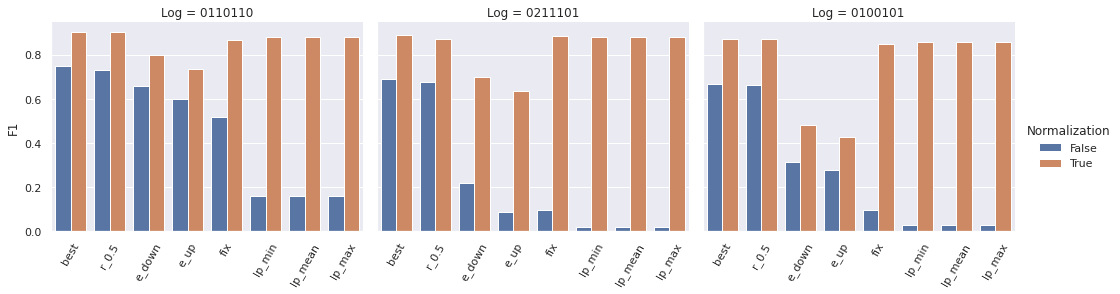

In [ ]:
g = sns.catplot(x="Heuristic", y="F1",
                hue="Normalization", col="Log",
                data=df, kind="bar",
                height=4, aspect=1.2);
g.set_xticklabels(rotation=60)
g.set(xlabel=None)

In [ ]:
heuristic_names

['best', 'r_0.5', 'e_down', 'e_up', 'fix', 'lp_min', 'lp_mean', 'lp_max']

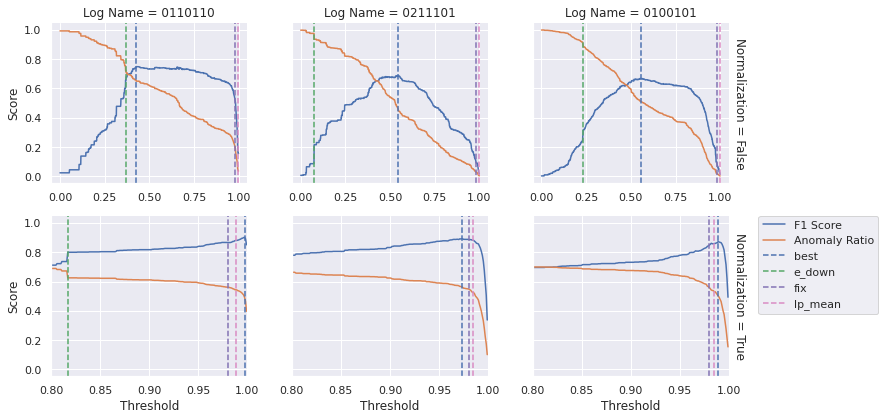

In [ ]:
sel_heuristics =[0,2,4,6] # Select Heuristics


plot_data = get_plot_data(th_df,id_vars=['Log Name','Normalization'])
g = sns.FacetGrid(plot_data, col="Log Name",  row="Normalization",hue='Metric',legend_out=True,aspect=1.4,
                 sharey=True,sharex=False,margin_titles=True,despine=True)
g.map_dataframe(sns.lineplot,"Threshold",'Score')

axes = [i for j in list(zip(g.axes[1],g.axes[0])) for i in j]
for i,ax in enumerate(axes):
    if i % 2== 0: ax.set_xlim([0.8,1])
    for j in sel_heuristics: #
        ax.axvline(heuristic_scores[i][j].name, ls='--',label=heuristic_names[j],color=color_palette[j])
plt.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
